In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from deepsvg.svglib.svg import SVG

from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.utils import to_gif
from deepsvg.svglib.geom import Bbox
from deepsvg.svg_dataset import SVGDataset, load_dataset
from deepsvg.utils.utils import batchify, linear

import torch

import os
import ntpath
import re
from tqdm import tqdm
import pickle
import random

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from cairosvg import svg2png
from PIL import Image
import cv2

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE

In [2]:
pretrained_folder = "pretrained"
pretrained_file = "run1_fake_KL0_singleGPU.pth.tar"
pretrained_path = os.path.join(pretrained_folder, pretrained_file)

from configs.deepsvg.hierarchical_ordered_gest_singleGPU import Config

cfg = Config()

# extract dataframe
dataset = load_dataset(cfg)
df = dataset.df

# define dataset folder
dataset_folder = os.path.dirname(cfg.meta_filepath)

# object saving pickle path
pickle_save_path = os.path.join(dataset_folder, pretrained_file.split('.')[0]+'.pkl')

# Images Array
jpg_img_array = np.zeros((len(df), 64, 64, 3))
png_img_array = np.zeros((len(df), 64, 64, 4))

# fig save path
fig_save_path = os.path.join(dataset_folder, 'plot.png')

In [3]:
def visualize_scatter_with_images(tsne_vec, images, save_path, figsize=(100,50), image_zoom=3):
    fig, ax = plt.subplots(figsize=figsize)
    for c, (xy, i) in enumerate(zip(tsne_vec, images)):
        x0, y0 = xy
        if c == 0:
            print("Size of one image: ", i.shape)
        if i.shape[0] == 1:
            img = OffsetImage(i,zoom=image_zoom, cmap="gray")
        else:
             img = OffsetImage(i,zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        ax.add_artist(ab)
    ax.set_axis_off()
    ax.update_datalim(tsne_vec)
    ax.autoscale()
    fig.savefig(save_path)

In [4]:
with open(pickle_save_path, 'rb') as handle:
    file = pickle.load(handle)

tensors = file['tensors']
jpg_paths = file['jpg_paths']
png_paths = file['png_paths']

In [5]:
# convert to np array

for i in tqdm(range(len(jpg_paths))):
    jpg = Image.open(jpg_paths[i])    
    jpg_img_array[i, :, : ,:] = np.array(jpg)
    
    png = Image.open(png_paths[i])    
    png_img_array[i, :, : ,:] = np.array(png)
    
jpg_img_array = jpg_img_array.astype(int)
png_img_array = png_img_array.astype(int)

100%|██████████| 20299/20299 [00:05<00:00, 3491.07it/s]


In [6]:
no_of_images = 100
image_width = 64

# skip = 15000
# images = jpg_img_array[skip:skip+no_of_images,:,:,:]
# features = tensors[skip:skip+no_of_images]

img_nums = list(np.random.randint(0, len(df), no_of_images))
images = jpg_img_array[img_nums,:,:,:]
features = tensors[img_nums,:]

tsne = TSNE(n_jobs= -1)
reduced = tsne.fit_transform(features)

Size of one image:  (64, 64, 3)


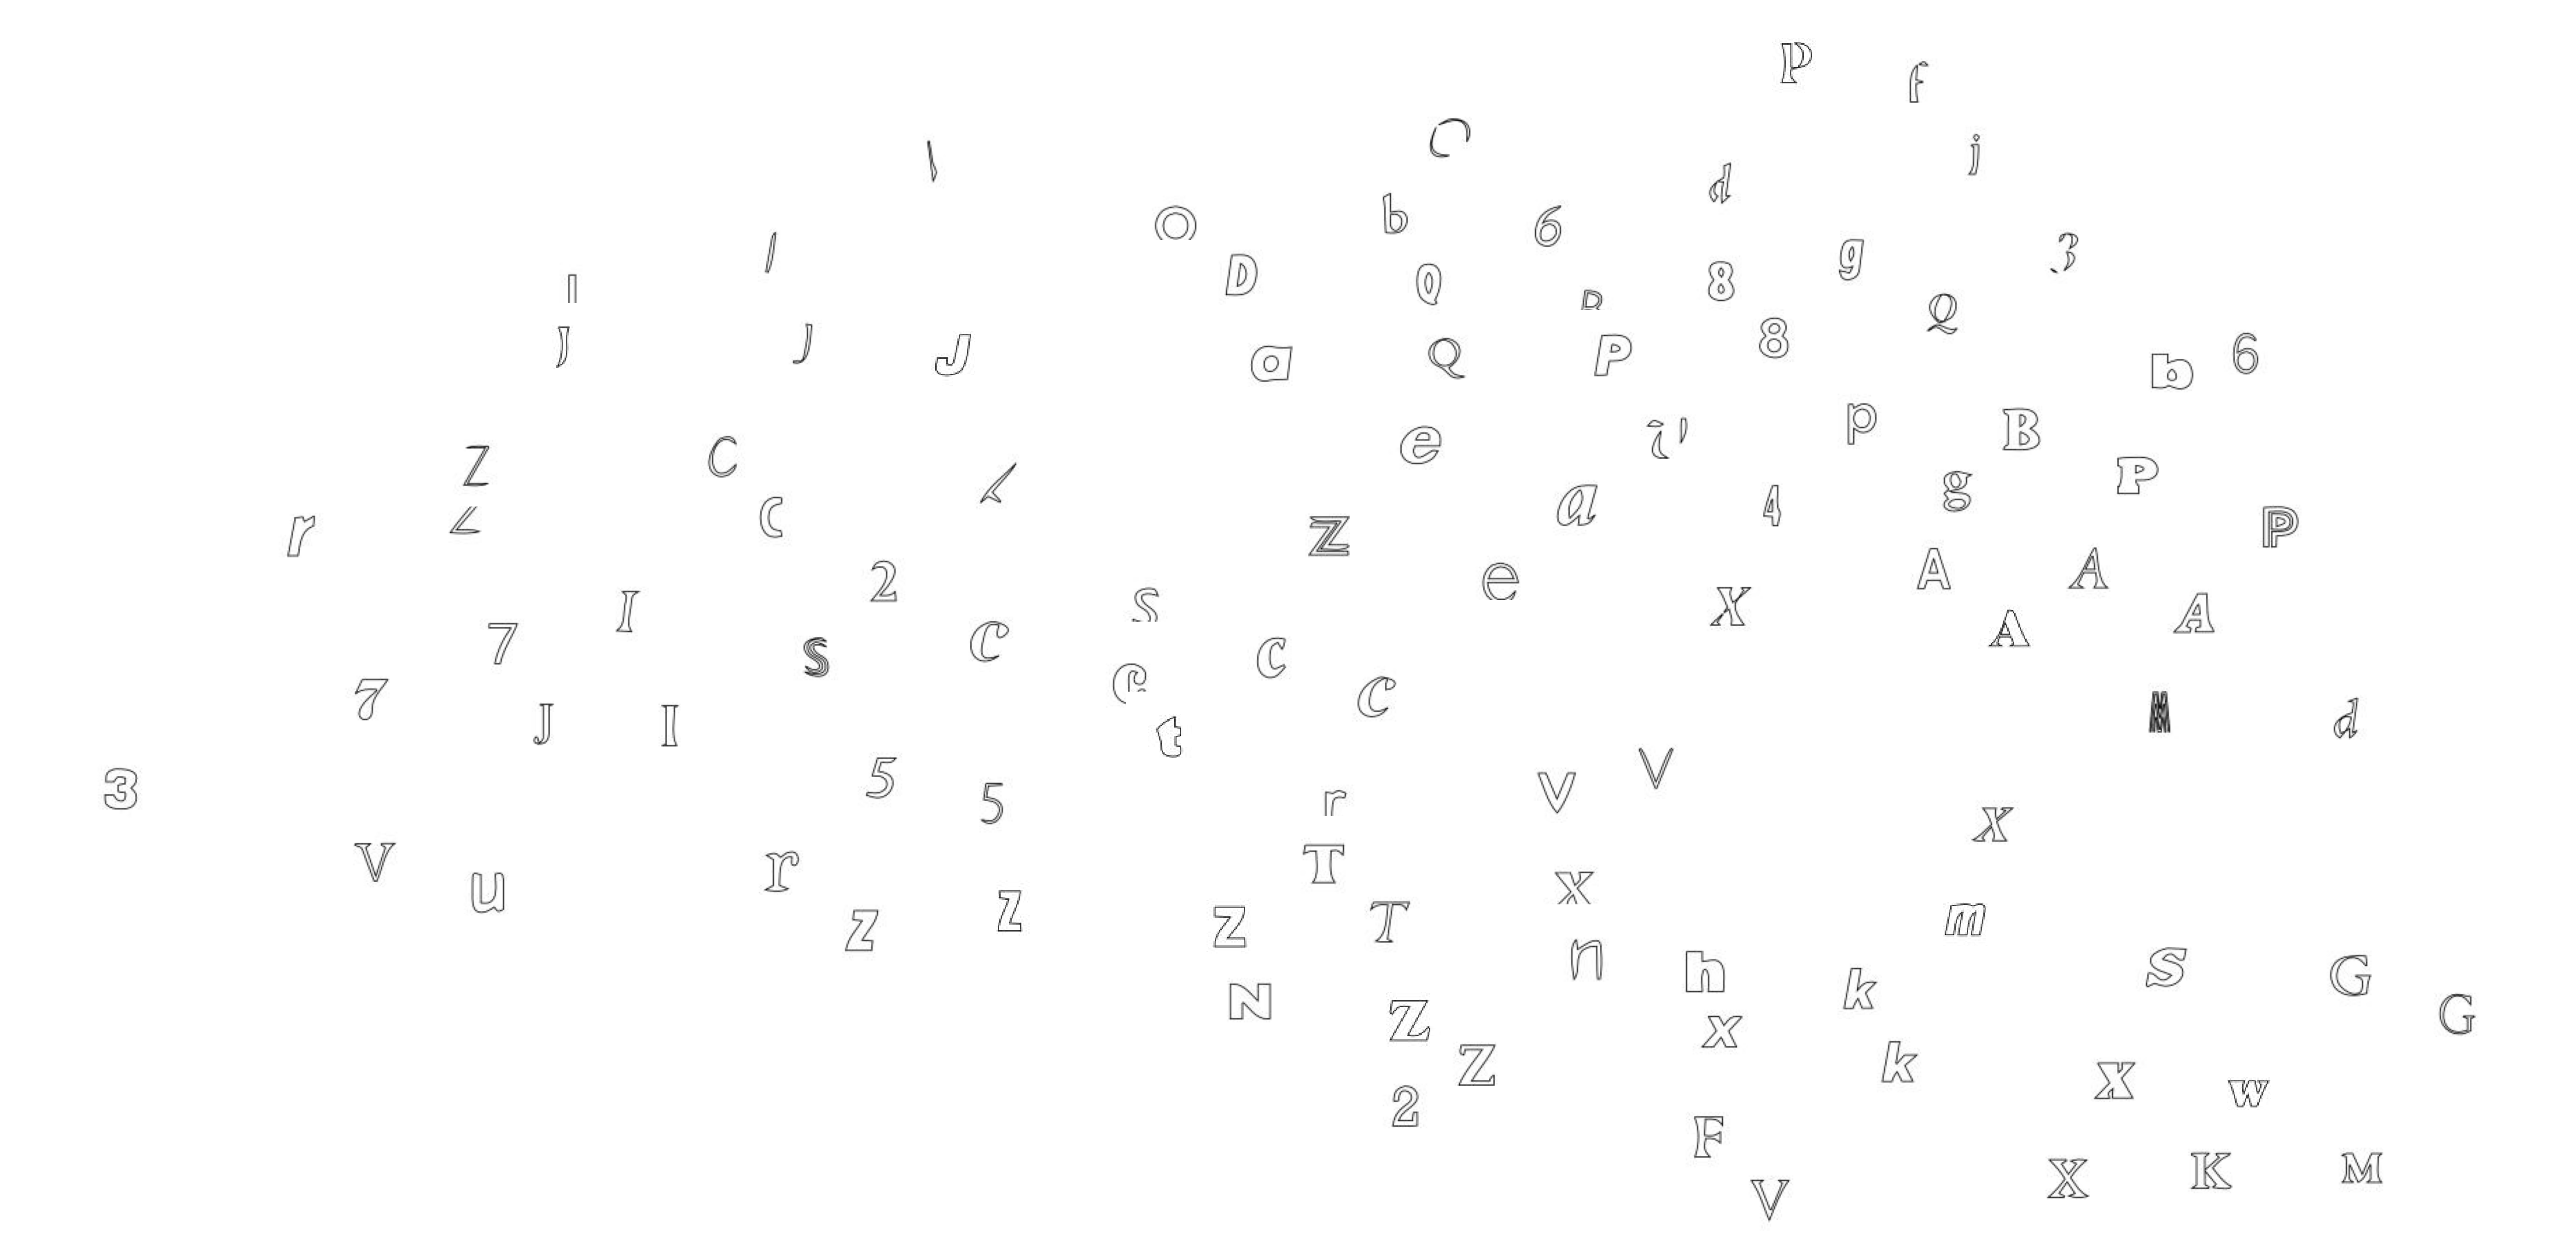

In [7]:
visualize_scatter_with_images(reduced, images, fig_save_path)

In [17]:
x = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73,
     74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 97, 98,
     99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
     115, 116, 117, 118, 119, 120, 121, 122]

In [18]:
len(x)

62

In [19]:
48+62

110

In [22]:
ord('0')

48